In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

import emcee
#import pymc3
import corner

#import dynesty

import sklearn
from sklearn import manifold
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# density estimation
from sklearn.neighbors import KernelDensity
from sklearn import mixture


# clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift

# Dimensional reduction
from sklearn.decomposition import PCA

# Cross validation
from sklearn.model_selection import GridSearchCV

## Fun with Gamma Ray Bursts

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



#### Python tip. Web request and smarter file reading

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


In [3]:
names # data structure names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
# import variables

# burst duration -> unit: seconds

T90 = np.array(data[names=='T90'][0],dtype=float)
T90_err = np.array(data[names=='T90_error'][0],dtype=float)

#redshift
z = np.array(data[names=='redshift'][0],dtype=float)

# time integrated total energy per unit surface -> unit: erg/cm^2
fluence = np.array(data[names=='fluence'][0],dtype=float)
fluence_err = np.array(data[names=='fluence_error'][0],dtype=float)

# positions:
ra = np.array(data[names=='ra'][0],dtype=float)
dec = np.array(data[names=='decl'][0],dtype=float)

# mask the real data
mask_real_data = (T90>0) & (fluence>0) #& (z>0)

T90_use = np.log10(T90[mask_real_data])
T90_err_use = np.log10(T90_err[mask_real_data])

fluence_use = np.log10(fluence[mask_real_data])
fluence_err_use = np.log10(fluence_err[mask_real_data])

ra_use = ra[mask_real_data]
dec_use = dec[mask_real_data]

z_use = z[mask_real_data]

<ipython-input-4-e6d26fe78d7a>:23: RuntimeWarning: invalid value encountered in log10
  T90_err_use = np.log10(T90_err[mask_real_data])
<ipython-input-4-e6d26fe78d7a>:26: RuntimeWarning: invalid value encountered in log10
  fluence_err_use = np.log10(fluence_err[mask_real_data])


I decided not to use the redshift in the analysis since the amount of usable data was too little and from a rough analysis I didn't find any specific clusters in the redshift dataset.

### Single component analysis: focus on T90

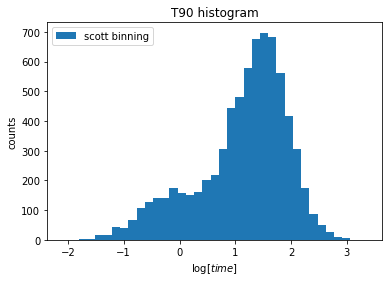

In [5]:
binning = 'scott'
_ = fancyhist(T90_use,bins=binning,label=binning+' binning')
plt.title('T90 histogram')
plt.xlabel(r'$\log{[time]}$')
plt.ylabel('counts')
plt.legend()

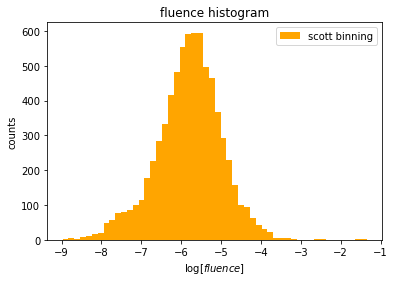

In [6]:
binning = 'scott'
_ = fancyhist(fluence_use,bins=binning,label=binning+' binning',color='orange')
plt.title('fluence histogram')
plt.xlabel(r'$\log{[fluence]}$')
plt.ylabel('counts')
plt.legend()

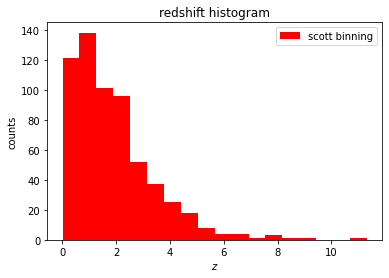

In [7]:
binning = 'scott'
_ = fancyhist(z[z>0],bins=binning,label=binning+' binning',color='red')
plt.title('redshift histogram')
plt.xlabel(r'$z$')
plt.ylabel('counts')
plt.legend()

No bi-modality in redshift and fluence

In [8]:
# density estimation cross validation to determine the best bandwith

bw_range = np.linspace(0.01,1,20)
K = 5 # 5 cross validation

X = T90_use[:,np.newaxis]

grid = GridSearchCV(KernelDensity(), {'bandwidth': bw_range}, cv= K) 
grid.fit(X) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.11421052631578947


#### KDE

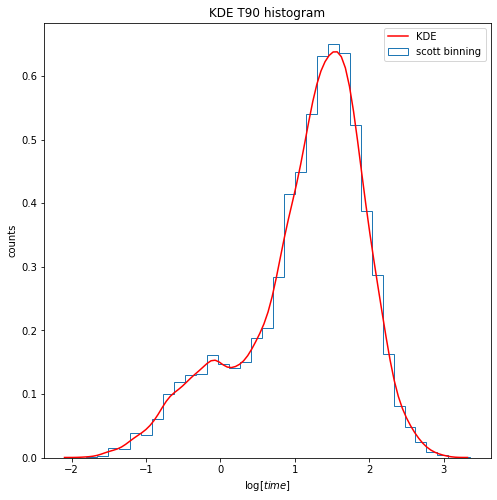

In [9]:
# KDE

kde = KernelDensity(bandwidth=h_opt)
kde.fit(X)

x_grid = np.linspace(T90_use.min(),T90_use.max(),100)
pdf_kde = np.exp(kde.score_samples(x_grid[:,np.newaxis]))

fig = plt.figure(figsize=(8,8))

binning = 'scott'
_ = fancyhist(T90_use,bins=binning,label=binning+' binning',density=True,histtype='step')
plt.title('KDE T90 histogram')
plt.xlabel(r'$\log{[time]}$')
plt.ylabel('counts')

plt.plot(x_grid,pdf_kde,label='KDE',color='red')

plt.legend()

#### K-Means clustering

Text(0.5, 1.0, 'KMeans clustering on T90 data')

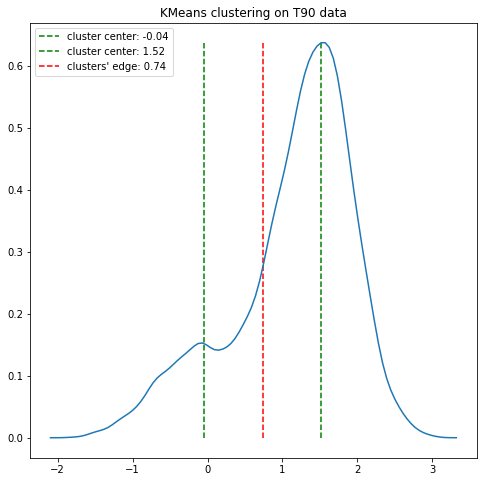

In [10]:
# with K-Means we can estimate the clustering

clf = KMeans(n_clusters=2) # seems to be two peaks
clf.fit(X)
labels_KM = clf.predict(X)
KM_centers = clf.cluster_centers_

edge = ( np.mean( [max(T90_use[labels_KM==0]), min(T90_use[labels_KM==1]) ]))

fig = plt.figure(figsize=(8,8))

plt.plot(x_grid, pdf_kde)
plt.vlines(KM_centers[0],0,max(pdf_kde),ls='--',color='green',label='cluster center: %.2f'%KM_centers[0])
plt.vlines(KM_centers[1],0,max(pdf_kde),ls='--',color='green',label='cluster center: %.2f'%KM_centers[1])
plt.vlines(edge,0,max(pdf_kde),ls='--',color='red',label="clusters' edge: %.2f"%edge)

plt.legend()
plt.title('KMeans clustering on T90 data')

However, it's not reliable the fact that the separation between the population is so sharp. Therefore we can think to use another method to determine the belonging of each point to one of the two populations

#### Gaussian mixture clustering

Text(0.5, 1.0, 'Gaussian mixture clustering on T90 data')

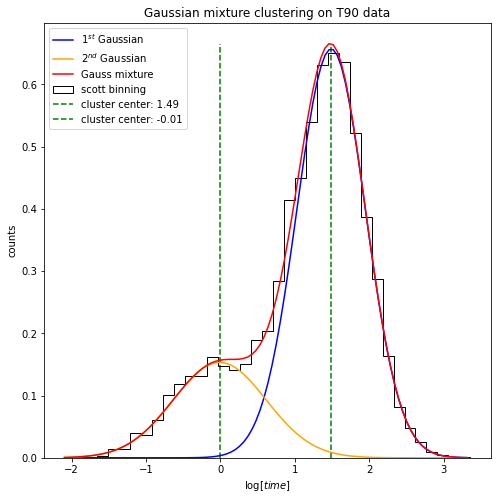

In [11]:
gauss_clf = mixture.GaussianMixture(n_components=2)
gauss_clf.fit(X)

pdf_gauss = np.exp(gauss_clf.score_samples(x_grid[:,np.newaxis]))

gauss_means = gauss_clf.means_
gauss_cov = gauss_clf.covariances_
gauss_w = gauss_clf.weights_

gauss_prob = gauss_clf.predict_proba(X)
gauss_labels = gauss_clf.predict(X)

# plot
fig = plt.figure(figsize=(8,8))

gauss1_plot = scipy.stats.norm(gauss_means[0],np.sqrt(gauss_cov[0][0]))
gauss2_plot = scipy.stats.norm(gauss_means[1],np.sqrt(gauss_cov[1][0]))

plt.plot(x_grid,gauss_w[0]*gauss1_plot.pdf(x_grid),color='blue',label='$1^{st}$ Gaussian')
plt.plot(x_grid,gauss_w[1]*gauss2_plot.pdf(x_grid),color='orange',label='$2^{nd}$ Gaussian')

plt.plot(x_grid,pdf_gauss,label='Gauss mixture',color='red')
plt.vlines(gauss_means[0],0,max(pdf_gauss),ls='--',color='green',label='cluster center: %.2f'%gauss_means[0])
plt.vlines(gauss_means[1],0,max(pdf_gauss),ls='--',color='green',label='cluster center: %.2f'%gauss_means[1])

binning = 'scott'
_ = fancyhist(T90_use,bins=binning,label=binning+' binning',density=True,histtype='step',color='black')
plt.title('T90 histogram')
plt.xlabel(r'$\log{[time]}$')
plt.ylabel('counts')

plt.legend(loc='upper left')
plt.title('Gaussian mixture clustering on T90 data')

Now let's see the accuracy in labelling one population or the other one with the two methods: Kmeans and Gaussian mixture:

In [12]:
conf_matrix = confusion_matrix(labels_KM,gauss_labels)
print(conf_matrix)

[[ 261 1573]
 [5429    0]]


### Multi-variable analysis

Text(0.5, 1.0, 'Fluence vs redshift')

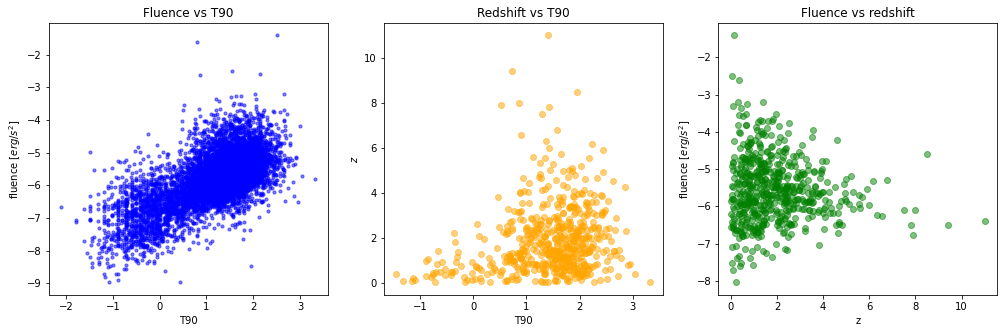

In [13]:
# visualize the data

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(17,5))

ax[0].scatter(T90_use,fluence_use,color='blue',alpha=0.5,s=10)
ax[0].set_xlabel('T90')
ax[0].set_ylabel('fluence $[erg/s^2]$')
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[0].set_title('Fluence vs T90')

ax[1].scatter(T90_use[z_use>0],z_use[z_use>0],color='orange',alpha=0.5)
ax[1].set_xlabel('T90')
ax[1].set_ylabel('$z$')
#ax[1].set_yscale('log')
#ax[1].set_xscale('log')
ax[1].set_title('Redshift vs T90')

ax[2].scatter(z_use[z_use>0],fluence_use[z_use>0],color='green',alpha=0.5)
ax[2].set_xlabel('z')
ax[2].set_ylabel('fluence $[erg/s^2]$')
#ax[2].set_yscale('log')
#ax[2].set_xscale('log')
ax[2].set_title('Fluence vs redshift')

We can distinguish two separated populations in the Fluence vs T90 plot. So I will focus on this two variables.

### Fluence vs T90

#### Kmeans

Text(0, 0.5, 'fluence')

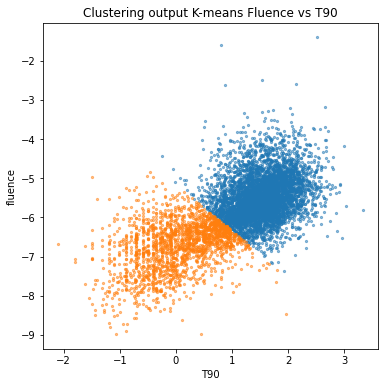

In [14]:
# K-means

X_T90_F = np.array([T90_use,fluence_use]).T

clf = KMeans(n_clusters=2)
clf.fit(X_T90_F)
labels = clf.predict(X_T90_F) #labels for each of the points

fig = plt.figure(figsize=(6,6))
# plot the data color-coded by cluster id
for ii in range(int(labels.max())+1):
    plt.scatter(X_T90_F[labels==ii,0], X_T90_F[labels==ii,1], 
                color='C%i'%ii,alpha=0.5,s=5)

plt.title('Clustering output K-means Fluence vs T90')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('T90')
plt.ylabel('fluence')

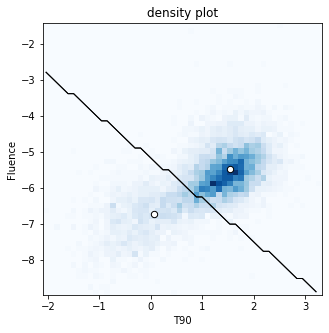

In [15]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

n_clusters = labels.max()+1

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_T90_F[:,0], X_T90_F[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = clf.cluster_centers_
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(Xgrid).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(Xgrid).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('T90')
ax.set_ylabel('Fluence')
ax.set_title('density plot')

plt.show()

#### Meanshift

This is the result of the clustering with Meanshift after several attemps to determine the best bandwidth (estimate_bandwidth ended in a failure) and combination of cluster_all and bin_seeding.

Number of clusters identified: 12


Text(0, 0.5, 'fluence')

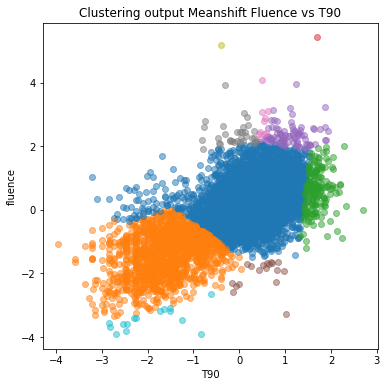

In [16]:
# Meanshift 
scaler = preprocessing.StandardScaler() # -> if estimate_bw is used, it is better to work without it 
#bw = sklearn.cluster.estimate_bandwidth(X_T90_F)

X_T90_F_scaled = scaler.fit_transform(X_T90_F)

ms = MeanShift(bandwidth=0.5,cluster_all=True,bin_seeding=True)

#ms.fit(scaler.fit_transform(X_T90_F))
ms.fit(X_T90_F_scaled)

labels_T90_F = ms.predict(X_T90_F_scaled)
print('Number of clusters identified:',labels_T90_F.max()+1)

fig = plt.figure(figsize=(6,6))

for ii in range(int(labels_T90_F.max())+1):
    plt.scatter(X_T90_F_scaled[labels_T90_F==ii,0], X_T90_F_scaled[labels_T90_F==ii,1], 
                color='C%i'%ii,alpha=0.5)

plt.title('Clustering output Meanshift Fluence vs T90')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('T90')
plt.ylabel('fluence')

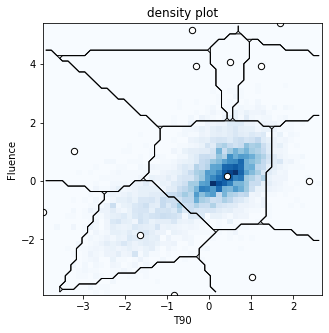

In [17]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

n_clusters = labels_T90_F.max()+1

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_T90_F_scaled[:,0], X_T90_F_scaled[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = ms.cluster_centers_
for i in range(n_clusters):
    ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],s=40, c='w', edgecolors='k')
    

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(Xgrid).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],linewidths=1, colors='k')

    H = ms.predict(Xgrid).reshape((50, 50))
    
#ax.set_xlim(xedges[0]+1, xedges[-1])
#ax.set_ylim(yedges[0], yedges[-1]-2)

ax.set_title('density plot')
ax.set_xlabel('T90')
ax.set_ylabel('Fluence')

plt.show()

It seems that Meanshift clusters some 'single points' as belonging to some group.

However, the overall separation between the two main cluster seems consistent with the two methods

### Error analysis

The idea is to check if the error is negligible in our analysis (as we have done until now). We can consider the error as negligible if it is of the same order of magnitude of the measurement.

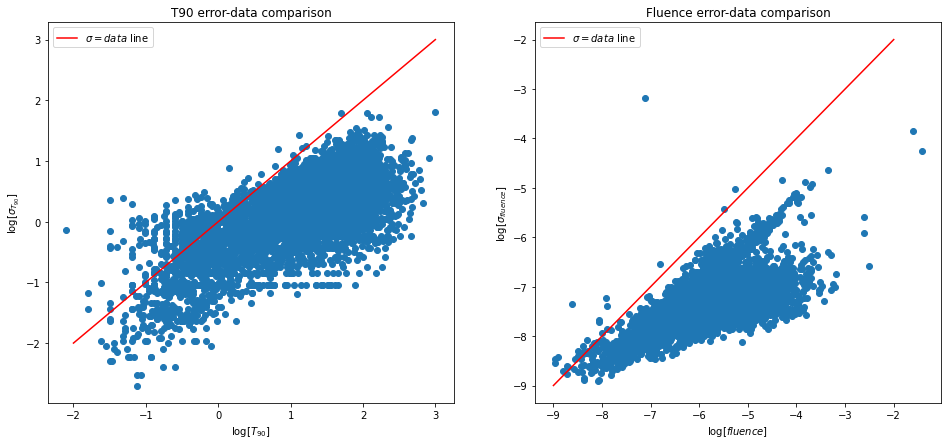

In [18]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,7))

T90_grid = np.arange(-2,4)
ax[0].plot(T90_grid,T90_grid,color='red',label='$\sigma=data$ line')

ax[0].scatter(T90_use,T90_err_use)
ax[0].set_xlabel(r'$\log{[T_{90}]}$')
ax[0].set_ylabel(r'$\log{[\sigma_{T_{90}}]}$')
ax[0].set_title('T90 error-data comparison')
ax[0].legend()

f_grid = np.arange(-9,-1)
ax[1].plot(f_grid,f_grid,color='red',label='$\sigma=data$ line')

ax[1].scatter(fluence_use,fluence_err_use)
ax[1].set_xlabel(r'$\log{[fluence]}$')
ax[1].set_ylabel(r'$\log{[\sigma_{fluence}]}$')
ax[1].set_title('Fluence error-data comparison')
ax[1].legend()

As we can see from the plots above, the assumption of negligible errors is not so far from what we observe.

Let's now try to reduce the data dimensionality, or to simply find a better basis on which we can better visualize and cluster the data.

### PCA approach

Let's try first to reduce the dimensionality starting from the full-dimensional space of variables:

In [19]:
# define the array
z_mask = z_use>0  # use also the redshift for this analysis, at the cost of reducing the data size

X_pca = np.vstack([T90_use[z_mask],fluence_use[z_mask],z_use[z_mask]]).T
#X_pca = np.vstack([T90_use,fluence_use,ra_use,dec_use]).T
X_pca.shape

(567, 3)

Text(0, 0.5, 'Eigenvalue 2')

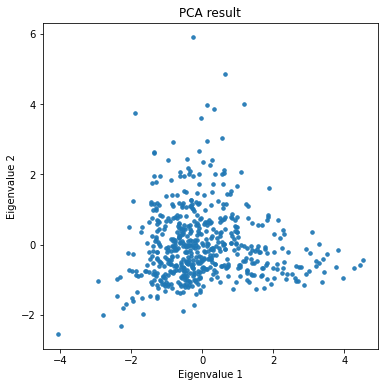

In [20]:
# try to reduce the dimensionality of the problem to two variables:

# rescale before PCA
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA() # all components
pca.fit(X_pca_scaled) # Do the fitting

X_reduced = pca.transform(X_pca_scaled) # reduce to 2-dim

fig = plt.figure(figsize=(6,6))

plt.scatter(X_reduced[:,0], X_reduced[:,1], s=50,marker=".", color='C0', alpha=0.9)

plt.title('PCA result')
plt.xlabel('Eigenvalue 1')
plt.ylabel('Eigenvalue 2')
#plt.xscale('log')


In [21]:
pca.explained_variance_ratio_

array([0.50874272, 0.35321478, 0.1380425 ])

In [22]:
pca.components_

array([[-0.71971604, -0.67672293, -0.15509643],
       [ 0.12330281, -0.34443601,  0.93067731],
       [ 0.68323147, -0.65069956, -0.33133796]])

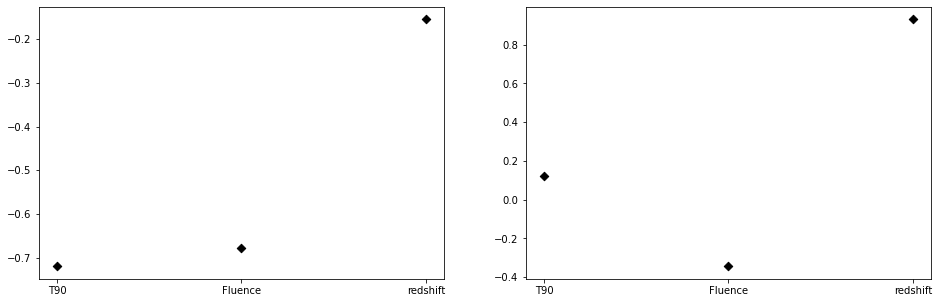

In [23]:
# let's see which are the variables encapsulating most of the variance:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,5))

variable_names = np.array(['T90','Fluence','redshift','ra','dec'])

for comp_1,comp_2,k in zip(pca.components_[0],pca.components_[1],variable_names):
    ax[0].scatter(k,comp_1,color='black',marker='D')
    ax[1].scatter(k,comp_2,color='black',marker='D')

It seems that the redshift contributes the more to the variance of the system, but as we have seen from our previous analysis, it doesn't present or contirbute to any multi-modality of the distribution of data, therefore I take this information as the result of an inconclusive PCA analysis. 

I also performed the same analysis using also the $ra$ and $dec$, getting the same result I found for the redshift. Therefore I conclude that the PCA analysis for this dataset is inconclusive

In [24]:
X_pca = np.vstack([T90_use[z_mask],fluence_use[z_mask],z_use[z_mask],ra_use[z_mask],dec_use[z_mask]]).T
X_pca.shape

(567, 5)

Text(0, 0.5, 'Eigenvalue 2')

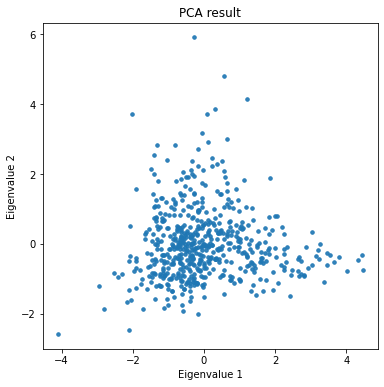

In [25]:
# try to reduce the dimensionality of the problem to two variables:

# rescaling
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA() # all components
pca.fit(X_pca_scaled) # Do the fitting

X_reduced = pca.transform(X_pca_scaled) # reduce to 2-dim

fig = plt.figure(figsize=(6,6))

plt.scatter(X_reduced[:,0], X_reduced[:,1], s=50,marker=".", color='C0', alpha=0.9)

plt.title('PCA result')
plt.xlabel('Eigenvalue 1')
plt.ylabel('Eigenvalue 2')
#plt.xscale('log')


In [26]:
pca.explained_variance_ratio_

array([0.30571486, 0.21319539, 0.21043762, 0.18811657, 0.08253556])

In [27]:
pca.components_

array([[-0.71715059, -0.67561798, -0.15612824, -0.036517  , -0.05937894],
       [ 0.11883544, -0.34230858,  0.90446484, -0.14603895,  0.1712278 ],
       [ 0.07847575,  0.01387956,  0.0107219 , -0.7156978 , -0.69376553],
       [ 0.02162606, -0.04937236,  0.22026343,  0.68031418, -0.69695862],
       [ 0.68187025, -0.65094924, -0.33005513,  0.04783728,  0.00965677]])

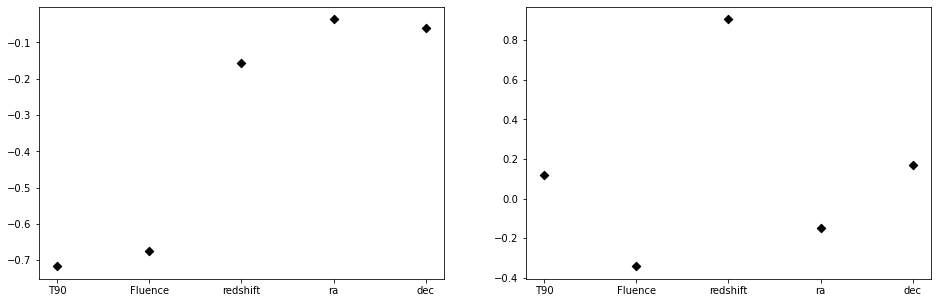

In [28]:
# let's see which are the variables encapsulating most of the variance:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,5))

variable_names = np.array(['T90','Fluence','redshift','ra','dec'])

for comp_1,comp_2,k in zip(pca.components_[0],pca.components_[1],variable_names):
    ax[0].scatter(k,comp_1,color='black',marker='D')
    ax[1].scatter(k,comp_2,color='black',marker='D')

# Stuff

It seems worst than before so I won't explore deeper

(0.1, 10000)

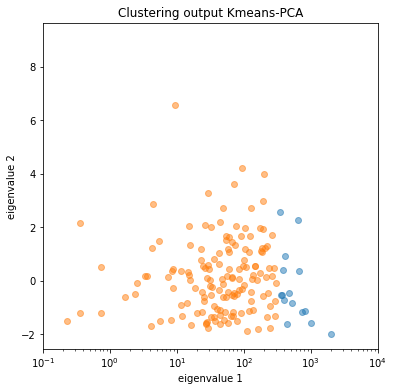

In [10]:
# K-MEANS clustering

clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X_reduced)
labels = clf.predict(X_reduced) #labels for each of the points

fig = plt.figure(figsize=(6,6))

# plot the data color-coded by cluster id
colors = ['C1', 'C0']
for ii in range(2):
    plt.scatter(X_reduced[labels==ii,0], X_reduced[labels==ii,1], 
                color=colors[ii],alpha=0.5)

plt.title('Clustering output Kmeans-PCA')
plt.xscale('log')
plt.xlabel('eigenvalue 1')
plt.ylabel('eigenvalue 2')
plt.xlim(0.1,10000)

(0.1, 10000)

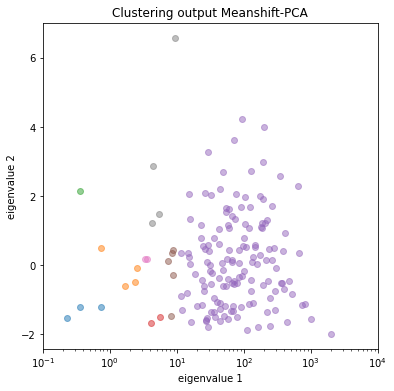

In [11]:
# MEAN-shift clustering
scaler = preprocessing.StandardScaler()
#bandwidth = 0.4
bandwidth = sklearn.cluster.estimate_bandwidth(X_reduced)

#ms = MeanShift(bandwidth=bandwidth,bin_seeding=False, cluster_all=True)
ms = MeanShift()

ms.fit(scaler.fit_transform(X_reduced))

labels = ms.predict(X_reduced)

fig = plt.figure(figsize=(6,6))

# plot the data color-coded by cluster id

for ii in range(int(labels.max())):
    plt.scatter(X_reduced[labels==ii,0], X_reduced[labels==ii,1], 
                color='C%i'%ii,alpha=0.5)

plt.title('Clustering output Meanshift-PCA')
plt.xscale('log')
plt.xlabel('eigenvalue 1')
plt.ylabel('eigenvalue 2')
plt.xlim(0.1,10000)

Better an analysis on the single variables!

### Single variable-variable analysis

In [14]:
idx_T90_F = labels_T90_F==scipy.stats.mode(labels_T90_F)[0] # indices of the sources belonging to the most populated cluster

In [15]:
idx_T90_F.shape

(565,)

### Redshift vs T90

Text(0, 0.5, 'z')

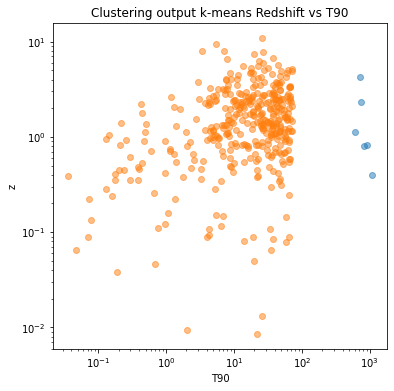

In [16]:
X_T90_z = np.array([T90_use,z_use]).T

clf = KMeans(n_clusters=5) 
clf.fit(X_T90_z)
labels = clf.predict(X_T90_z) #labels for each of the points

fig = plt.figure(figsize=(6,6))
# plot the data color-coded by cluster id
colors = ['C1', 'C0']
for ii in range(2):
    plt.scatter(X_T90_z[labels==ii,0], X_T90_z[labels==ii,1], 
                color=colors[ii],alpha=0.5)

plt.title('Clustering output k-means Redshift vs T90')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T90')
plt.ylabel('z')

Number of clusters identified: 9


Text(0, 0.5, 'z')

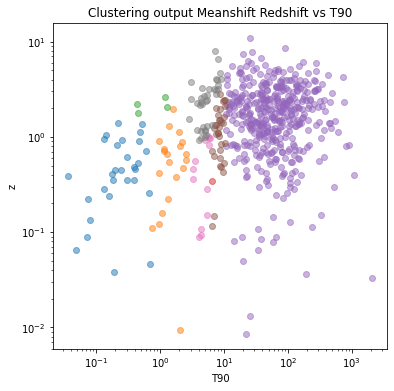

In [17]:
# Meanshift 

scaler = preprocessing.StandardScaler()
#bandwidth = 0.4

ms = MeanShift(cluster_all=True)

ms.fit(scaler.fit_transform(X_T90_z))

labels_T90_z = ms.predict(X_T90_z)
print('Number of clusters identified:',labels_T90_z.max()+1)

fig = plt.figure(figsize=(6,6))

for ii in range(int(labels_T90_z.max())):
    plt.scatter(X_T90_z[labels_T90_z==ii,0], X_T90_z[labels_T90_z==ii,1], 
                color='C%i'%ii,alpha=0.5)

plt.title('Clustering output Meanshift Redshift vs T90')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T90')
plt.ylabel('z')

In [18]:
idx_T90_z = labels_T90_z==scipy.stats.mode(labels_T90_z)[0] # indices of the sources belonging to the most populated cluster

In [19]:
len(idx_T90_z)

565

### Fluence vs Redshift

Text(0.5, 0, 'z')

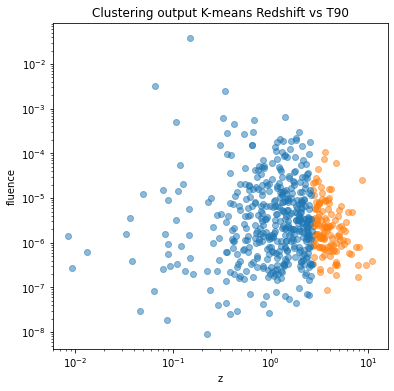

In [20]:
X_z_fluence = np.array([z_use,fluence_use]).T

clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X_z_fluence)
labels = clf.predict(X_z_fluence) #labels for each of the points

fig = plt.figure(figsize=(6,6))
# plot the data color-coded by cluster id
colors = ['C1', 'C0']
for ii in range(2):
    plt.scatter(X_z_fluence[labels==ii,0], X_z_fluence[labels==ii,1], 
                color=colors[ii],alpha=0.5)

plt.title('Clustering output K-means Redshift vs T90')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('fluence')
plt.xlabel('z')

Number of clusters identified: 4


Text(0.5, 0, 'z')

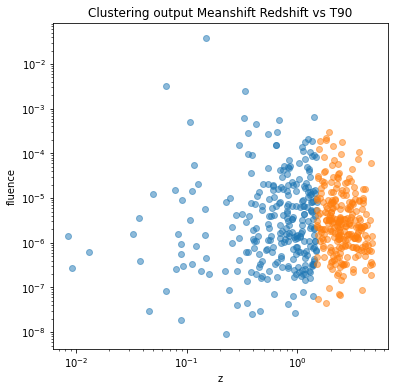

In [21]:
# Meanshift 

scaler = preprocessing.StandardScaler()
#bandwidth = 0.4

ms = MeanShift(cluster_all=True)

ms.fit(scaler.fit_transform(X_z_fluence))

labels = ms.predict(X_z_fluence)
print('Number of clusters identified:',labels.max()+1)

fig = plt.figure(figsize=(6,6))

for ii in range(int(labels.max())):
    plt.scatter(X_z_fluence[labels==ii,0], X_z_fluence[labels==ii,1], 
                color='C%i'%ii,alpha=0.5)

plt.title('Clustering output Meanshift Redshift vs T90')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('fluence')
plt.xlabel('z')

### Results data analysis

Check if the most populated cluster are consistent between F vs T90 and F vs redshift

In [22]:
# find where the two identified population differs
idx_comparison = np.where((idx_T90_F==idx_T90_z))[0]

print("The main population has been identified with the %.3f of accuracy"%(len(idx_comparison)/len(idx_T90_F)) )

The main population has been identified with the 0.998 of accuracy


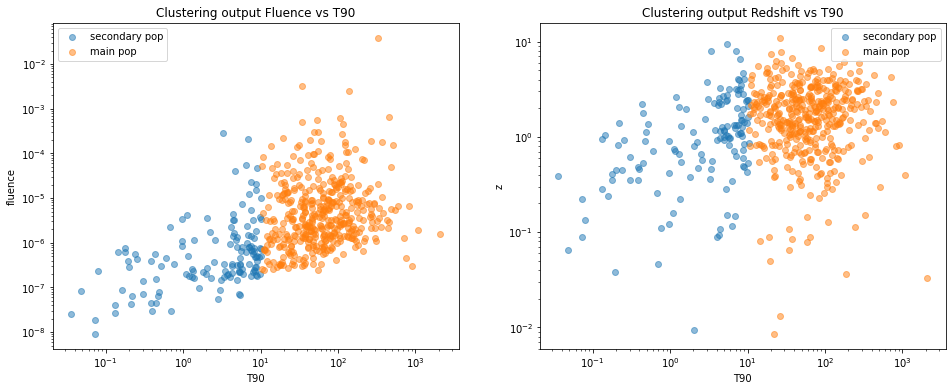

In [40]:
# build two different populations:

# fluence vs T90:
labels_pop_F = np.zeros(X_T90_F.shape[0],dtype=int)
labels_pop_F[idx_T90_F==True] = int(1)

# redshift vs T90
labels_pop_z = np.zeros(X_T90_z.shape[0],dtype=int)
labels_pop_z[idx_T90_z==True] = int(1)

# plot the results:

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,6))

label = ['secondary pop','main pop']
for ii in range(2):
    ax[0].scatter(X_T90_F[labels_pop_F==ii,0], X_T90_F[labels_pop_F==ii,1],color='C%i'%ii,alpha=0.5,label=label[ii])
    ax[1].scatter(X_T90_z[labels_pop_z==ii,0], X_T90_z[labels_pop_z==ii,1],color='C%i'%ii,alpha=0.5,label=label[ii])
    
ax[0].set_title('Clustering output Fluence vs T90')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('T90')
ax[0].set_ylabel('fluence')
ax[0].legend()

ax[1].set_title('Clustering output Redshift vs T90')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('T90')
ax[1].set_ylabel('z')
ax[1].legend()

### Try with all the features together

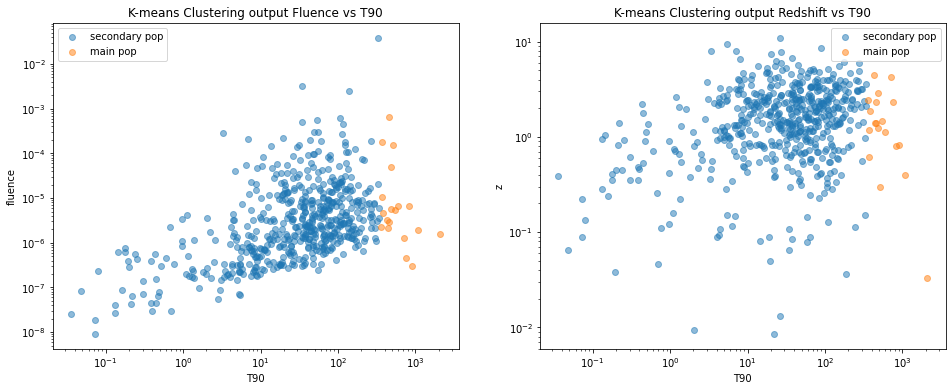

In [70]:
# K-means
clf = KMeans(n_clusters=2)
clf.fit(X)
labels = clf.predict(X) #labels for each of the points

# plot with projection on two axis

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,6))

label = ['secondary pop','main pop']
for ii in range(2):
    ax[0].scatter(X[:,0][labels==ii], X[:,1][labels==ii],color='C%i'%ii,alpha=0.5,label=label[ii])
    ax[1].scatter(X[:,0][labels==ii], X[:,2][labels==ii],color='C%i'%ii,alpha=0.5,label=label[ii])
    
ax[0].set_title('K-means Clustering output Fluence vs T90')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('T90')
ax[0].set_ylabel('fluence')
ax[0].legend()

ax[1].set_title('K-means Clustering output Redshift vs T90')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('T90')
ax[1].set_ylabel('z')
ax[1].legend()

Number of clusters identified: 10


Text(0, 0.5, 'z')

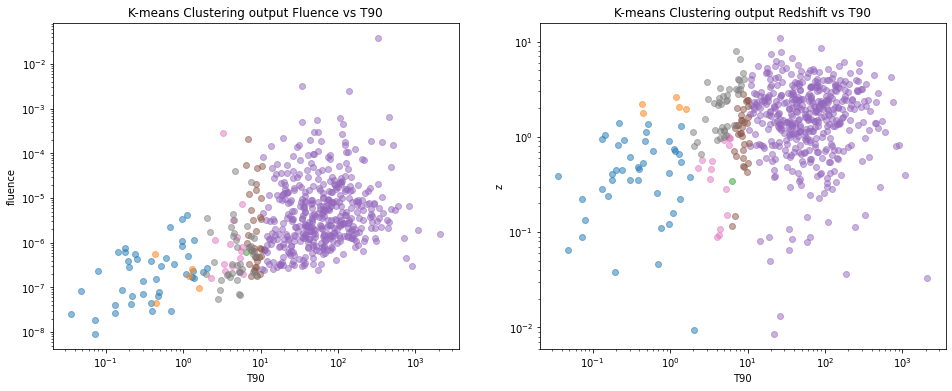

In [68]:
# Meanshift

scaler = preprocessing.StandardScaler()
#bandwidth = 0.4

ms = MeanShift(cluster_all=True)

ms.fit(scaler.fit_transform(X))

labels = ms.predict(X)
print('Number of clusters identified:',labels.max()+1)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,6))

for ii in range(labels.max()):
    ax[0].scatter(X[:,0][labels==ii], X[:,1][labels==ii],color='C%i'%ii,alpha=0.5)
    ax[1].scatter(X[:,0][labels==ii], X[:,2][labels==ii],color='C%i'%ii,alpha=0.5)
    
ax[0].set_title('K-means Clustering output Fluence vs T90')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('T90')
ax[0].set_ylabel('fluence')
#ax[0].legend()

ax[1].set_title('K-means Clustering output Redshift vs T90')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('T90')
ax[1].set_ylabel('z')
#ax[1].legend()

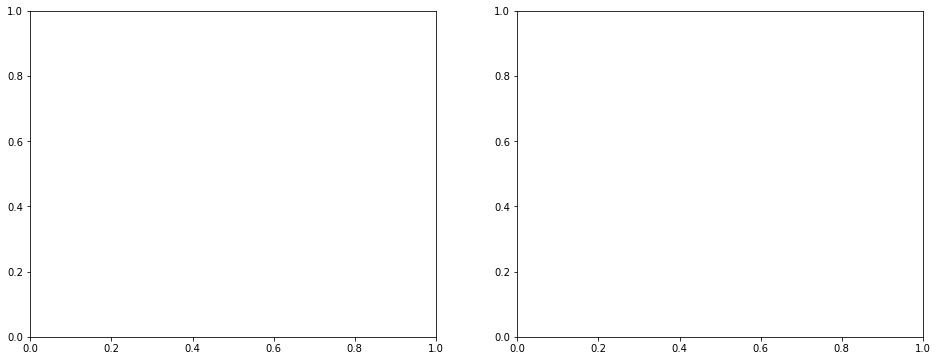

In [45]:
# plot with boundaries:

fig = plt.subplots(ncols=2,nrows=1,figsize=(16,6))

# Compute a 2D histogram  of the input
H_F, xedges_F, yedges_F = np.histogram2d(X_T90_F[:,0], X_T90_F[:,1], 50)

# plot density
ax[0].imshow(H_F.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges_F[0], xedges_F[-1],
                  yedges_F[0], yedges_F[-1]],
          cmap='Blues')

# plot cluster centers
#cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
#ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],s=40, c='w', edgecolors='k')

ax[0].set_title('Clustering output Fluence vs T90')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('T90')
ax[0].set_ylabel('fluence')
ax[0].legend()

In [ ]:
# plot cluster boundaries
x_centers_F = 0.5 * (xedges_F[1:] + xedges_F[:-1])
y_centers_F = 0.5 * (yedges_F[1:] + yedges_F[:-1])

Xgrid_F = np.meshgrid(x_centers_F, y_centers_F)
Xgrid_F = np.array(Xgrid_F).reshape((2, 50 * 50)).T

H_F = ms.predict(scaler.transform(Xgrid_F)).reshape((50, 50))

for i in range(2):
    Hcp = H_F.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax[0].contour(x_centers_F, y_centers_F, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H_F = ms.predict(scaler.transform(Xgrid_F)).reshape((50, 50))
    
ax[0].set_xlim(xedges_F[0], xedges_F[-1])
ax[0].set_ylim(yedges_F[0], yedges_F[-1])

ax[0].set_xlabel('Eigenvalue 1')
ax[0].set_ylabel('Eigenvalue 2')

plt.show()

In [59]:
# import variables

# burst duration -> unit: seconds

T90 = np.array(data[names=='T90'][0],dtype=float)
T90_err = np.array(data[names=='T90_error'][0],dtype=float)

#redshift
z = np.array(data[names=='redshift'][0],dtype=float)

# time integrated total energy per unit surface -> unit: erg/cm^2
fluence = np.array(data[names=='fluence'][0],dtype=float)
fluence_err = np.array(data[names=='fluence_error'][0],dtype=float)

# positions:
ra = np.array(data[names=='ra'][0],dtype=float)
dec = np.array(data[names=='decl'][0],dtype=float)

# mask the real data
mask_real_data = (T90!=-999) & (fluence!=-999) #& (z!=-999)

T90_log = np.log10(T90[mask_real_data])
T90_err_log = np.log10(T90_err[mask_real_data])

fluence_log = np.log10(fluence[mask_real_data])
fluence_err_log = np.log10(fluence_err[mask_real_data])

z_log = np.log10(z[mask_real_data])

# mask log 
mask_log = (T90_log!=-np.inf) & (fluence_log!=-np.inf)# & (z_log!=-np.inf)

T90_use = T90_log[mask_log]
T90_err_use = T90_err_log[mask_log]

fluence_use = fluence_log[mask_log]
fluence_err_use = fluence_err_log[mask_log]

z_use = z_log[mask_log]

<ipython-input-59-090534715c68>:23: RuntimeWarning: invalid value encountered in log10
  T90_err_log = np.log10(T90_err[mask_real_data])
<ipython-input-59-090534715c68>:25: RuntimeWarning: divide by zero encountered in log10
  fluence_log = np.log10(fluence[mask_real_data])
<ipython-input-59-090534715c68>:26: RuntimeWarning: divide by zero encountered in log10
  fluence_err_log = np.log10(fluence_err[mask_real_data])
<ipython-input-59-090534715c68>:26: RuntimeWarning: invalid value encountered in log10
  fluence_err_log = np.log10(fluence_err[mask_real_data])
<ipython-input-59-090534715c68>:28: RuntimeWarning: invalid value encountered in log10
  z_log = np.log10(z[mask_real_data])
